In [21]:
%load_ext autoreload
%autoreload 2

import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import time
from IPython import display

import contextlib
import os
from importlib import reload

import torchvision
from torch import autograd
import torch.nn as nn
import torch.nn.functional as F
import torch

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']
plt.rcParams['font.size'] = 12

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import renyi
import utils
from renyi import renyi_mixture_divergence, rbf_kernel, poly_kernel, generic_kernel
from renyi import test_mixture_divergence, renyi_mixture_divergence_stable
from renyi import renyi_mixture_divergence, renyi_sim_divergence, renyi_sim_divergence_stable
from renyi import breg_mixture_divergence_stable, breg_sim_divergence_stable
from renyi import breg_mixture_divergence, breg_sim_divergence

In [23]:
# torch.set_default_dtype(torch.float64)

class GeneratorFC(nn.Module):
    def __init__(self, input_size, output_size, hidden_dims):
        super(GeneratorFC, self).__init__()
        self.layers = []

        prev_dim = input_size
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
#             self.layers.append(nn.BatchNorm1d(hidden_dim))
            self.layers.append(nn.ReLU())
            prev_dim = hidden_dim
        self.layers.append(nn.Linear(prev_dim, output_size))

        self.layer_module = nn.ModuleList(self.layers)

    def forward(self, x):
        out = x
        for layer in self.layer_module:
            out = layer(out)
        return out

In [24]:
from sklearn.datasets.samples_generator import make_swiss_roll

d, z_dim, gen_hiddens = 2, 2, [500, 500]
batch_size_p = 200
batch_size_q = 200

In [28]:
generator = GeneratorFC(z_dim, d, gen_hiddens).cuda()

g_optimizer = torch.optim.Adam(generator.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [29]:
alpha = 1
sigma_mult = 1

# emp_probs = 2*torch.ones(1, batch_size//2).cuda()/batch_size
emp_probs_p = torch.ones(1, batch_size_p).cuda()/batch_size_p
emp_probs_q = torch.ones(1, batch_size_q).cuda()/batch_size_q

kernel = lambda x, y: generic_kernel(x, y, lambda u, v: rbf_kernel(u, v, sigmas=[0.2 * sigma_mult], log=True))
# kernel = lambda x, y: generic_kernel(x, y, lambda u, v: multiquad_kernel(u, v, sigma=0.2))
# kernel = lambda x, y: generic_kernel(x, y, lambda u, v: poly_kernel(u, v, degree=2))

D = lambda x, y: breg_mixture_divergence_stable(emp_probs_p, x, emp_probs_q, y, kernel, symmetric=False)

# D = lambda x, y: renyi_mixture_divergence_stable(emp_probs_p, x, emp_probs_q, y, kernel, alpha,
#                                                  use_avg=False, use_full=False, symmetric=True)
# D = lambda x, y: test_mixture_divergence(emp_probs_p, x, emp_probs_q, y, kernel,
#                                          symmetric=True, use_avg=False)

KeyboardInterrupt: 

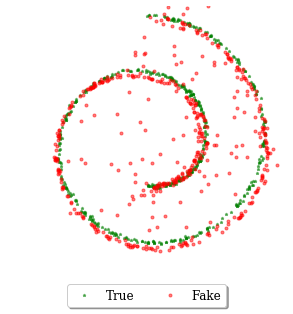

In [31]:
# for g in g_optimizer.param_groups:
#     g['lr'] = 1e-4

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for _ in range(1000):
    
    g_optimizer.zero_grad()
    
    x_real = torch.Tensor(make_swiss_roll(batch_size_p, noise=0.1)[0][:, [0, 2]]/10).cuda()
    x_real += 0.01 * torch.randn_like(x_real)
    
    z = torch.randn(batch_size_q, z_dim).cuda()
    with contextlib.nullcontext():  # autograd.detect_anomaly():
        x_fake = generator(z)

#         x = x_real[:batch_size//2]
#         x_prime = x_real[batch_size//2:]
#         y = x_fake[:batch_size//2]
#         y_prime = x_fake[batch_size//2:]

#         loss = D(x, y) + D(x_prime, y) + D(x, y_prime) + D(x_prime, y_prime) - 2*D(y, y_prime)

        loss = D(x_real, x_fake)
#         loss = D(x_fake, x_real)

        if _ % 50 == 0:
#             print("%d - %.4f" % (_, loss.item()))
            ax.clear()
            x_real = make_swiss_roll(500, noise=0.1)[0][:, [0, 2]]/10
            z = torch.randn(500, z_dim).cuda()
            x_fake = generator(z).data.cpu().numpy()

            ax.plot(x_real[:, 0], x_real[:, 1], 'g*', alpha=0.5, label='True', markersize=3)
            ax.plot(x_fake[:, 0], x_fake[:, 1], 'ro', alpha=0.5, label='Fake', markersize=3)
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.00), fancybox=True, shadow=True, ncol=2);

            ax.set_xlim(-1.5, 1.5)
            ax.set_ylim(-1.5, 1.5)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            fig.canvas.draw()

            display.display(plt.gcf())
            time.sleep(0)
            display.clear_output(wait=True)

        loss.backward()

    g_optimizer.step()